In [120]:
from datetime import datetime, date, time
import os 
import tarfile
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from wikidata.client import Client

In [5]:
# freebase ID search in wikidata

WIKIDATA_QUERY = """
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P646 ?statement0.
      ?statement0 (ps:P646) "%s".
    }

  }
}

"""

In [6]:
#extract tar data
data_folder_tar = './data/'
data_path_tar = os.path.join(data_folder_tar, 'MovieSummaries.tar.gz')

In [5]:
# open file
file = tarfile.open(data_path_tar)
  
# extract files
file.extractall('./data')
  
# close file
file.close()

In [7]:
#column names of df_movie
Name_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']

In [9]:
#read movie.metadata as dataframe
data_folder = os.path.join('data', 'MovieSummaries')
data_path = os.path.join(data_folder,'movie.metadata.tsv')
df_movie = pd.read_csv(data_path, sep ='\t', header = None, names = Name_movie, na_values = ['{}', ' '], lineterminator='\n')


In [10]:
df_movie.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [11]:
#filtering the strings : removing freebase IDs in front of languages, countries and genres
def filtering_function(column):
    _filtered = []
    i = 0
    for s in column:
        S_r = ''
        c = 1
        if (isinstance(s, str)):
            if s.find(',') == -1:
                S_r = s[(s.find(':')+3):(s.find(':}')-1)]
            else:
                a = s
                S_r = a[(a.find(':')+3):(a.find(',')-1)]
                a = a[(a.find(',')+1):]
                while c>0:
                    if a.find(',') == -1:
                        S_r =  S_r + ', ' + a[(a.find(':')+3):(a.find(':}')-1)]
                        c = 0
                    else:
                        S_r = S_r + ', ' + a[(a.find(':')+3):(a.find(',')-1)]
                        a = a[(a.find(',')+1):]
        else:
            S_r = 'None' 
        _filtered.append(S_r)
    return _filtered

#Language Filtering
language_filtered = filtering_function(df_movie['Movie languages'])
df_movie['Movie languages filtered'] = language_filtered

#Countries Filtering
countries_filtered = filtering_function(df_movie['Movie countries'])
df_movie['Movie countries filtered'] = countries_filtered

#Genres Filtering
genres_filtered = filtering_function(df_movie['Movie genres'])
df_movie['Movie genres filtered'] = genres_filtered

In [28]:
#movie release date converted to year (as an int)

def date(df_date):
    dates = []
    len_year = 4
    for date in df_date:
        if not (pd.isna(date)):
            date = str(date)
            if len(date) > len_year:
                dates.append(date[0:4])
            else:
                dates.append(date)
        else:
            dates.append(date)
            
    return np.array(dates, dtype=float)


In [29]:
df_movie["dates_filtered"] = date(df_movie["Movie release date"])

In [30]:
df_movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered,dates_filtered
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norwegian Language,Norway,"Crime Fiction, Drama",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",German Language,Germany,Drama,1983.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,United States of America,Drama,2011.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",English Language,"Ireland, United Kingdom","Biographical film, Drama, Documentary",2011.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,United States of America,"Satire, Comedy",1972.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A...",1992.0


In [33]:
np.min(df_movie["dates_filtered"])

1010.0

In [36]:
np.sum(df_movie["dates_filtered"] < 1800)

1

In [40]:
df_movie.loc[df_movie["dates_filtered"] < 1800, "dates_filtered"] = np.nan
df_movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie languages filtered,Movie countries filtered,Movie genres filtered,dates_filtered
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norwegian Language,Norway,"Crime Fiction, Drama",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",German Language,Germany,Drama,1983.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",English Language,United States of America,Drama,2011.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",English Language,"Ireland, United Kingdom","Biographical film, Drama, Documentary",2011.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",English Language,United States of America,"Satire, Comedy",1972.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Japanese Language,Japan,"Science Fiction, Japanese Movies, Adventure, A...",1992.0


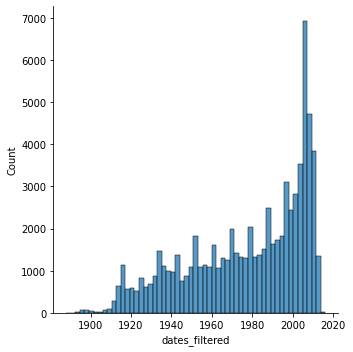

In [41]:
sns.displot(data=df_movie, x="dates_filtered", kind="hist")
plt.show()

In [25]:
df_movie.dtypes

Wikipedia movie ID            int64
Freebase movie ID            object
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie runtime               float64
Movie languages              object
Movie countries              object
Movie genres                 object
Movie languages filtered     object
Movie countries filtered     object
Movie genres filtered        object
dates_filtered               object
dtype: object

In [51]:
#column names of df_character
Name_character = ['Wikipedia Movie ID','Freebase Movie ID', 'Movie release date', 'Character Name','Actor DOB', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'unknown 1', 'unknown 2', 'Freebase character map']

In [52]:
#read character.metadata as dataframe
data_path = os.path.join(data_folder,'character.metadata.tsv')
df_character = pd.read_csv(data_path, sep ='\t', header = None, names = Name_character, na_values = ' ', lineterminator='\n')

In [53]:
df_character.head(10)

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,unknown 1,unknown 2,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [54]:
df_character["dates_filtered"] = date(df_character["Movie release date"])
df_character["dates_filtered_DOB"] = date(df_character["Actor DOB"])
df_character = df_character.drop(["unknown 1", "unknown 2"], 1)
df_character

/tmp/ipykernel_4774/3363371858.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_character = df_character.drop(["unknown 1", "unknown 2"], 1)


,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map,dates_filtered,dates_filtered_DOB
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/01y9xg,2001.0,1977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0b_vcv,1992.0,1970.0
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0bx7_j,1992.0,1965.0
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/022g44,1957.0,1941.0
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmm,1957.0,NaN


In [55]:
#regroup ethnicities together
temp_df = df_character['Actor ethnicity'].groupby(df_character['Actor ethnicity']).agg(['count'])
temp_df = temp_df.reset_index()
temp_df

,Actor ethnicity,count
0,/m/01267,10
1,/m/012c1l,141
2,/m/012f86,32
3,/m/012fh,1
4,/m/01336l,224
...,...,...
474,/m/0j4w_,43
475,/m/0j6x8,43
476,/m/0x67,10159
477,/m/0xff,5


In [56]:
def get_ethnicity(freebase_id):
    # freebase -> wikidata
    query = WIKIDATA_QUERY % freebase_id
    req = requests.get("https://query.wikidata.org/sparql",
                       params={"format": "json", "query": query})
    try :
        data = req.json()
        wikidata_id = data["results"]["bindings"][0]["itemLabel"]["value"]
        
    except:
        return np.nan

    client = Client()
    entity = client.get(wikidata_id, load=True)
    
    return entity.label


In [57]:
temp_temp_df = temp_df.copy()

In [58]:
temp_temp_df

,Actor ethnicity,count
0,/m/01267,10
1,/m/012c1l,141
2,/m/012f86,32
3,/m/012fh,1
4,/m/01336l,224
...,...,...
474,/m/0j4w_,43
475,/m/0j6x8,43
476,/m/0x67,10159
477,/m/0xff,5


In [59]:
#Match every freebase ethnicity ID to the ethnicity, if it is found in Wikidata

temp_temp_df = temp_df.copy()
et = []
for i in range(len(temp_df['Actor ethnicity'])):
    df_temp_ethnicity = temp_df.iloc[i:i+1]
    for ethnicity in df_temp_ethnicity['Actor ethnicity'] :
        eth_tra = get_ethnicity(ethnicity)
        j = 0
        while ((type(eth_tra) == float) & (j<100)):
            eth_tra = get_ethnicity(ethnicity)
            j += 1
        et.append(eth_tra)

KeyboardInterrupt: 

In [ ]:
temp_temp_df['Actor ethnicity'] = et

In [ ]:
tmp = []
for i in range (len(temp_temp_df['Actor ethnicity'])):
    if not (pd.isna(temp_temp_df['Actor ethnicity'][i])):
        tmp.append(str(temp_temp_df['Actor ethnicity'][i]))
    else:
        tmp.append(temp_temp_df['Actor ethnicity'][i])

In [ ]:
 temp_temp_df['Actor ethnicity'] = tmp

In [ ]:
temp_temp_df.head()

In [ ]:
df_character_bis = df_character.copy()

In [87]:
for i in range(len(temp_df['Actor ethnicity'])) :
    df_character = df_character.replace(temp_df['Actor ethnicity'][i], temp_temp_df['Actor ethnicity'][i])

In [88]:
df_character

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,unknown 1,unknown 2,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,English people,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


# More analysis on the density of the graph

In [60]:
df_actor_red = df_character[["Wikipedia Movie ID", "Freebase character map", "Actor Name", "dates_filtered"]]
df_actor_red

,Wikipedia Movie ID,Freebase character map,Actor Name,dates_filtered
0,975900,/m/03wcfv7,Wanda De Jesus,2001.0
1,975900,/m/0346l4,Natasha Henstridge,2001.0
2,975900,/m/01vw26l,Ice Cube,2001.0
3,975900,/m/034hyc,Jason Statham,2001.0
4,975900,/m/01y9xg,Clea DuVall,2001.0
...,...,...,...,...
450664,913762,/m/0b_vcv,Dorothy Elias-Fahn,1992.0
450665,913762,/m/0bx7_j,Jonathan Fahn,1992.0
450666,28308153,/m/022g44,David Hemmings,1957.0
450667,28308153,/m/0g8ngmm,Roberta Paterson,1957.0


In [62]:
df_actor_red.loc[df_actor_red["dates_filtered"] < 1800, "dates_filtered"] = np.nan

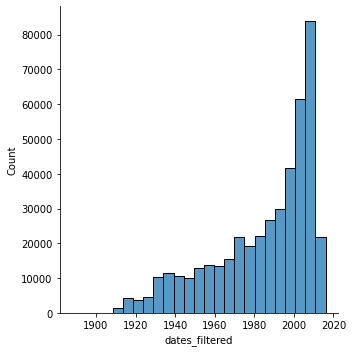

In [66]:
sns.displot(data=df_actor_red, x="dates_filtered", bins=25)

In [175]:
duration = 5
actor_edge_data = []

for year in tqdm(df_actor_red.loc[~np.isnan(df_actor_red["dates_filtered"]), "dates_filtered"].unique()):
    df = df_actor_red
    df = df[(year <= df["dates_filtered"]) & (df["dates_filtered"] < year + duration)]
    df = df.drop(columns=["dates_filtered", "Actor Name"])
    df = df.merge(df, on="Wikipedia Movie ID")
    df = df[df["Freebase character map_x"] != df["Freebase character map_y"]]
    df = df.groupby("Freebase character map_x").agg("count")
    for (actor, info) in df.iterrows():
        num_edges = info["Wikipedia Movie ID"]
        actor_edge_data.append({"actor": actor, "year": year, "edges": num_edges})

df_actor_edge = pd.DataFrame(actor_edge_data)
df_actor_edge

  0%|          | 0/126 [00:00<?, ?it/s]

,actor,year,edges
0,/m/010p3,2001.0,9
1,/m/010wx,2001.0,4
2,/m/010xjr,2001.0,145
3,/m/011_3s,2001.0,37
4,/m/011_ww,2001.0,5
...,...,...,...
1120981,/m/0n5_11v,1904.0,3
1120982,/m/0n5_125,1904.0,3
1120983,/m/0n5_12j,1904.0,3
1120984,/m/0n5_12w,1904.0,3


<AxesSubplot: xlabel='year', ylabel='edges'>

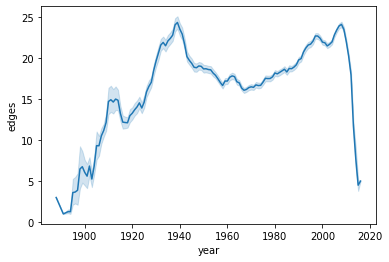

In [177]:
sns.lineplot(data=df_actor_edge, x="year", y="edges")